## Exercise 2

### Choice of Business

**Coffee on the go** is an integral part of many peoples' morning routine. High-throughput sales of coffee to take-out customers (such as commuters) can be considerably more profitable than selling coffee to stay-in patrons who spend many hours working or reading on the premises while consuming little. This biases successful cafés towards co-locating with heavy foot traffic. 

An interesting hybrid arises when coffee shops deploy mobile points of sale. One such example is [Ipsento's Nitro Tricycle](https://www.instagram.com/nitro_coffee/). Basically, the nitro tricycle is a cargo bike that can sell a limited amount of coffee at an arbitrary location. Ipsento, for example, frequently deploys its bike to the [California Blue Line stop](https://goo.gl/maps/xgqr8F6L1iw) in the summer.

![The Ipsento Nitro Tricycle](https://rawgit.com/kenben/ideo_ds/master/notebooks/pics/nitrobike.jpg "nitro bike")
(The Ipsento Nitro Tricycle. Image source: https://www.instagram.com/nitro_coffee/)

Clearly, a mobile point of sale promises several advantages: It allows coffee shops with sub-prime locations to access the high-throughput commuter market without having to acquire real estate; its location can dynamically respond to changes in demand (such as a weekend open-air festival) and supply (such as a new Dunkin Donuts within a CTA station); and it builds curiosity and brand recognition for its home base. On the other hand, the bike can only serve an extremely limited number of products (such as pre-brewed batch coffee); it can only stock a limited number of servings per deployment; and its operation is highly weather-dependent.

### 1. What questions could you potentially explore/answer with this data?

The CTA dataset should enable us to develop a better understanding of expected business demand. Given that our coffee bike is mobile and serves a product targeted at commuters, we should be able to identify different locations for different days (potentially not just days of the week, but days across the year) from a reasonably large pool of candidates. This way, we could deploy the bike to the highest-demand location and, hopefully, increase revenue over our current deployment heuristic.

### 2. Ideally, what other data would you gather or combine to learn even more?

To fully explore optimal routing for our coffee bike, we would greatly benefit from a range of additional data sources:

- **Spatial locations**: The current dataset does not provide information on _where_ the stations actually are. This knowledge is crucial for our bike deployment, however. 
 
 
- **Hourly ridership**: The current dataset has daily ridership counts. That is too coarse for our purposes, as our business has strong demand dependencies on time of day. Hourly ridership counts would be much better. In their absence, we would have to rely on very rough heuristics (for example, we could assume that central locations see outgoing traffic mostly in the evening, while suburban locations see outgoing traffic mostly in the morning). Fortunately, hourly data should (at least in theory) be available.  
 
 
- **Overall attendance, not just boardings**: The current dataset counts turnstile entries. Our business is likely not dependent on the directionality of travelers, and so our demand will be a function of incoming traffic just as much as of outgoing traffic. Unfortunately for us, the CTA's smart card system ("Ventra") does not require tap-outs (unlike systems in some other cities). Many L stations have exits that do not even require passing through turnstiles at all. Therefore, this data might be extremely challenging to collect. We might have to make strong assumptions to estimate arriving traffics based on location and time of day. 
 
 
- **Physical layout of locations**: Our coffee bike is well-suited for curbside sales. This makes it a good fit for stations with few entrances/exits (such as where the L runs above ground). Stations that are tucked away in shopping centers or under skyscrapers, or that have a high number of entrances, are less ideal. We would also need to know where we can legally do sales, and where we would need specific permits. 
 
 
- **Competitors**: It would be extremely useful to know which locations are already being served by competitors. Some competitive analysis would actually be possible using another one of the city's open datasets: The [food inspections dataset](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5) gives addresses (and food safety violations) of many Chicago establishments. Alternatively, we might be able to scrape this data from Google. 
 
 
- **Customer preferences by time of day and weather**: To know which product (e.g. hot or cold coffee) to bring on the bike, and to estimate what percentage of commuters might be potential customers, it would be nice to have data on customers preferences. Potentially, we could estimate these preferences from the point-of-sale software of our project partner, instead of relying on traditional market surveys.
 
 
- **Weather predictions**: Knowing the weather in advance, in combination with customer preference data, could help us optimize which product (e.g., cold or hot coffee) to offer the next day. It can also be helpful to inform if the bike can deploy at all.

### 3. How would you want to see data presented, to make it actionable by you or others?
For the application at hand, I would present the following results:

- a **map of stations** within reasonable vicinity to the bike's home base  
 
 
- overlays for this map (or graphs), displaying **estimated customer volume and estimated demand** per day of the week (or better, per hour) for each of the stations
 
 
- **interpretable, rule-like insights** into the dependence of demand and product preference on weather, time of year, and other special events (like sports games or summer music festivals)
 
 
- 2-3 stations that could be **viable business opportunities**, but are currently not being served by the bike

Note that the project partner is presumably a low-tech environment, and that the analysis needs to be interpreted and acted upon without additional technical resources.

Of course, you could take this problem to technologically interesting (and, for this project partner, entirely inappropriate) extremes: Real-time traffic and CTA data could be merged to make by-the-minute predictions of coffee demand across the city, and a fleet of bikes could be dynamically routed to optimally serve that demand. The bikes would be internet-enabled, communicating the amount of remaining coffee and their current whereabouts to a central system that then optimally routes them to different locations, taking into account travel times, supply levels, and demand predictions.

### Data Merging

The available dataset is clearly missing information (such as location) that we would like to have:

In [155]:
import pandas as pd
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sns.set(font_scale=1.5)

In [156]:
df = pd.read_csv('../data/clean.csv')
df['date'] = pd.to_datetime(df.date)

In [157]:
df.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,2001-01-01,U,290
1,40010,Austin-Forest Park,2001-01-02,W,1240
2,40010,Austin-Forest Park,2001-01-03,W,1412
3,40010,Austin-Forest Park,2001-01-04,W,1388
4,40010,Austin-Forest Park,2001-01-05,W,1465


Fortunately, the city's open data portal provides additional data. There are two datasets that list details on stations; one in shapefile format, one as a CSV. The shapefile only provides point-information, and neither of the two lists the exact `station_id` that we have seen in our previous dataset. So let's pull the CSV-formatted dataset:

In [189]:
! wget https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD -O ../data/stations.csv

--2018-02-07 10:24:21--  https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../data/stations.csv’

    [ <=>                                   ] 47,888      --.-K/s   in 0.02s   

Last-modified header invalid -- time-stamp ignored.
2018-02-07 10:24:21 (2.04 MB/s) - ‘../data/stations.csv’ saved [47888]



In [158]:
st = pd.read_csv('../data/stations.csv')
st.columns = st.columns.map(str.lower)

In [159]:
st.shape

(300, 17)

In [160]:
st.head()

,stop_id,direction_id,stop_name,station_name,station_descriptive_name,map_id,ada,red,blue,g,brn,p,pexp,y,pnk,o,location
0,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30213,N,35-Bronzeville-IIT (Harlem-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [161]:
set.intersection(set(st.stop_id.unique()), set(df.station_id.unique()))

set()

`stop_id` and `station_id` don't overlap! However, the station dataset has a `map_id` that looks promising:

In [162]:
st.map_id.nunique()

143

It's surprisingly not unique (there are 300 rows in the CSV). Let's check that:

In [163]:
st.sort_values(by='map_id').head()

,stop_id,direction_id,stop_name,station_name,station_descriptive_name,map_id,ada,red,blue,g,brn,p,pexp,y,pnk,o,location
44,30001,E,Austin (O'Hare-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
45,30002,W,Austin (Forest Pk-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
146,30003,E,Harlem (63rd-bound),Harlem/Lake,Harlem/Lake (Green Line),40020,True,False,False,True,False,False,False,False,False,False,"(41.886848, -87.803176)"
147,30004,W,Harlem (Terminal arrival),Harlem/Lake,Harlem/Lake (Green Line),40020,True,False,False,True,False,False,False,False,False,False,"(41.886848, -87.803176)"
244,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),40030,True,False,False,True,False,False,False,False,False,False,"(41.885412, -87.725404)"


So that's because the station dataset encodes direction. Re-check:

In [164]:
station_to_location = st[['map_id', 'location']].drop_duplicates()
station_to_location.shape

(144, 2)

Almost! There's still one row too many in there:

In [165]:
station_to_location[station_to_location.duplicated('map_id', keep=False)]

,map_id,location
254,41400,"(41.867405, -87.62659)"
256,41400,"(41.867368, -87.627402)"


Aha! One station moved. 

In [166]:
doubles = station_to_location[station_to_location.duplicated('map_id', keep=False)]
doubles.location

m = folium.Map(location=(41.867405, -87.62659), zoom_start=15)
folium.Marker((41.867405, -87.62659), popup='duplicate').add_to(m)
folium.Marker((41.867368, -87.627402), popup='duplicate').add_to(m)

In [168]:
m

Ok, so the Roosevelt station moved or had a new entrance (or something like that). For our purposes, this is the same station, so we can simply drop the duplicates:

In [169]:
station_to_location = station_to_location.drop_duplicates(subset='map_id')

Now let's parse out the latitude and longitude:

In [170]:
station_to_location.loc[:,'lat'], station_to_location.loc[:,'long'] = \
    station_to_location.loc[:,'location']\
                       .str.replace('(','')\
                       .str.replace(')','')\
                       .str.split(', ').str

station_to_location['lat'] = station_to_location.lat.astype(float)
station_to_location['long'] = station_to_location.long.astype(float)

Let's add in the station name:

In [171]:
station_to_location = station_to_location.merge(
                         df[['station_id','stationname']].drop_duplicates(),
                         left_on='map_id', right_on='station_id'
                        )

station_to_location = station_to_location.drop('station_id',1)

In [172]:
station_to_location.head()

,map_id,location,lat,long,stationname
0,40830,"(41.857908, -87.669147)",41.857908,-87.669147,18th
1,40120,"(41.829353, -87.680622)",41.829353,-87.680622,35th/Archer
2,41120,"(41.831677, -87.625826)",41.831677,-87.625826,35-Bronzeville-IIT
3,41270,"(41.816462, -87.619021)",41.816462,-87.619021,43rd
4,41080,"(41.809209, -87.618826)",41.809209,-87.618826,47th-South Elevated


Now we're ready to pull the datasets together:

In [173]:
df = df.merge(station_to_location.drop('stationname',1), 
             how='left',
             left_on='station_id', right_on='map_id')

Let's check where location data is missing in the merged dataset:

In [174]:
df.loc[df.location.isnull(),['stationname', 'location']].drop_duplicates()

,stationname,location
111174,Randolph/Wabash,NaN
290276,Washington/State,NaN
367365,Madison/Wabash,NaN
863465,Homan,NaN


This isn't great, but let's leave it as is right now. It _would_ be nice to be able to filter by train line, so let's look into merging that data in, as well:

In [175]:
st_to_line = st[['map_id','ada','red','blue','g','brn','p','pexp','y','pnk','o']].drop_duplicates()

In [176]:
st_to_line.shape

(158, 11)

That's a few rows too many -  a quick look shows that these are, for example, loop stops where the two directions have differences in which lines they serve. We don't care about train directionality, so we take the union of lines per station:

In [177]:
st_to_line = st_to_line.groupby('map_id').sum().astype(bool)

In [178]:
st_to_line.shape

(143, 10)

Great. Let's merge it together:

In [179]:
df = df.merge(st_to_line, how='left', left_on='station_id', right_index=True)

In [180]:
df.head()

,station_id,stationname,date,daytype,rides,map_id,location,lat,long,ada,red,blue,g,brn,p,pexp,y,pnk,o
0,40010,Austin-Forest Park,2001-01-01,U,290,40010.0,"(41.870851, -87.776812)",41.870851,-87.776812,False,False,True,False,False,False,False,False,False,False
1,40010,Austin-Forest Park,2001-01-02,W,1240,40010.0,"(41.870851, -87.776812)",41.870851,-87.776812,False,False,True,False,False,False,False,False,False,False
2,40010,Austin-Forest Park,2001-01-03,W,1412,40010.0,"(41.870851, -87.776812)",41.870851,-87.776812,False,False,True,False,False,False,False,False,False,False
3,40010,Austin-Forest Park,2001-01-04,W,1388,40010.0,"(41.870851, -87.776812)",41.870851,-87.776812,False,False,True,False,False,False,False,False,False,False
4,40010,Austin-Forest Park,2001-01-05,W,1465,40010.0,"(41.870851, -87.776812)",41.870851,-87.776812,False,False,True,False,False,False,False,False,False,False


### Around home base

Armed with the merged data, we can now have a look at the surroundings of the coffee shop. Ipsento, the presumed home base for the bike, seems to be at `41.918815, -87.687258`.

In [181]:
def basic_map():
    """Simple convenience function that returns a folium map, centered on Ipsento """

    ipsento = (41.918815, -87.687258)
    max_dist = 1.5 # in miles
    meters_per_mile = 1609

    m = folium.Map(location=ipsento, zoom_start=13)

    # circle of max_dist miles around the coffee shop
    folium.features.Circle(
        location=ipsento,
        radius=max_dist*meters_per_mile,
        popup='%.2f miles radius'%max_dist,
        color='#3b8c20',
        fill=True,
        fill_color='#3b8c20'
    ).add_to(m)

    # marker for the coffee shop
    folium.Marker(
        location=ipsento,
        popup='Ipsento Coffee Shop',
        icon=folium.Icon(color='#3b8c20', icon='info-sign')
    ).add_to(m)
    
    return m

Let's plot the coffee shop and L station locations, and highlight the 1.5 miles around the coffee shop:

In [182]:
m = basic_map()

for _, s in station_to_location.iterrows():
    folium.Marker(
        location=(float(s['lat']),float(s['long'])),
        popup=s['stationname'].replace("'",""), # folium is buggy!
        icon=folium.Icon(color='black')
    ).add_to(m)

m

### Average rides around home base by weekday/weekend

Let's look at the average daily ridership last summer (the summer data is more relevant for the bike, as it can't really go out in the cold). We'll split this into two plots - one for weekday, for one weekends and holidays:

In [183]:
# dates of interest (last summer)
date_range = [pd.to_datetime('2017-05-01'), pd.to_datetime('2017-09-01')]

# restrict data to that range, find daily means per station
recent_rides_weekday = df[ (df.date>=date_range[0])&(df.date<=date_range[1])&(df.daytype=='W') ]\
                .groupby('station_id')[['rides']].mean()

recent_rides_weekend = df[ (df.date>=date_range[0])&(df.date<=date_range[1])&(df.daytype!='W') ]\
                .groupby('station_id')[['rides']].mean()

# scale to 0-1 for coloring
myscale = lambda x: (x-min(x)) / (max(x) - min(x))

def to_color(x, cmap='hot'):
    """ Convenience function to translate floaty data in x to hex color.
        Scales the data to 0-1 first. cmap is the name of the matplotlib
        colormap.
    """
    mycmap = plt.get_cmap(cmap)
    color_data = mycmap(myscale(x))[:,0:3]
    color_data = pd.DataFrame(index=x.index, data=color_data)
    color_data = color_data.apply(matplotlib.colors.rgb2hex,1)
    return color_data

# translate the ridership averages to color data
recent_rides_weekday['color'] = to_color(recent_rides_weekday.rides)
recent_rides_weekend['color'] = to_color(recent_rides_weekend.rides)

### Average Weekday Ridership Map

Note that these maps are interactive - if you click on the colored circles, it'll tell you the name of the stop.

In [184]:
# It turns out that there is a really nice package that handles all the
# color scaling for you! - I haven't used branca before, but hooray.

import branca.colormap as cm

def ride_heatmap(ride_data,
                 heatmap_caption,
                 station_to_location=station_to_location):
    """ Just a convenience function.
        ride_data is a data frame, indexed by station_id, with column 'rides'.
    """
    
    colormap = cm.linear.RdYlGn.scale(ride_data.rides.min(), 
                                      ride_data.rides.max())

    m = basic_map()

    # add colored circles for the CTA stations
    for idx, s in station_to_location.iterrows():

        this_rides = ride_data.loc[s['map_id'],'rides']
        this_color = colormap.rgb_hex_str(this_rides)

        folium.features.Circle(
            location=(float(s['lat']),float(s['long'])),
            radius=150,
            popup=s['stationname'].replace("'","") + ' (%.f'%this_rides + ' rides)',
            color=this_color,
            fill=True,
            fill_color=this_color,
            fill_opacity=0.8
        ).add_to(m)

    m.add_child(colormap)
    colormap.caption = heatmap_caption
    
    return m

Plot the average weekday ridership. **Click** on circles to see station names and exact average numbers.

In [185]:
ride_heatmap(recent_rides_weekday, 'Average weekday ridership (for summer)')

### Average Weekend Ridership Map

Again, **click** on the colored circles to get the station name and average ridership number.

In [186]:
ride_heatmap(recent_rides_weekend, 'Average weekend ridership (for summer)')

Just looking at the map, it is a little bit surprising that the bike is choosing the California Blue Line stop, instead of going either to Damen or Logan Square. Those two stops seem to have higher average ridership, and they're not that far away! On top, both Western and California seem to have similar ridership numbers - so if California's ridership numbers are good enough for the bike, then why not stay right at Western, instead of losing time biking up to California?

Alas, with a little bit of real-world knowledge, it turns out that Logan Square, Western, and Damen are quite saturated with coffee shops already (from the top of my head, there are at least two at Logan Square, two at Western, and on the order of $10^{23}$ at Damen). Additionally, the Logan Square stop is underground, with three entrances spread out along Milwaukee Avenue. California, on the other hand, lacks an immediate coffee shop. (Until very recently, at least: Collectivo Coffee picked up on the opportunity, and opened a new, large coffee shop in a new luxury apartment building right next to the California Blue Line stop this winter.)

Alternatively, the bike could shoulder the longer trip to Fullerton (2 miles to the east), which has ridership numbers well above those of the Blue Line stops. Again, however, there are more competitors there (I believe there is a Donkin Donuts _in_ the Fullerton station).

Still, this might be a reasonable proposition. Consider that at the Logan Square/California/Western/Damen stops, the bike competes with high-end shops (such as Intelligentsia, Collectivo, La Colombe, and Passionhouse), all of which serve "fancy" drinks, and easily charge in excess of \$4 per cup. The bike is technically equipped to serve "nitro cold brew", a high-end cold coffee that commonly retails for \$4-\$6.

Logistically, it makes sense for the bike to target a high-price, low-volume market, because it can only carry a limited number of servings per deployment. Unfortunately, such offerings place it in direct competition with the above shops.

At Fullerton, however, the existing competition (Dunkin Donuts) only serves a low-price, high-volume product. The combination of high total ridership numbers and lack of similarly positioned competitors could make Fullerton an interesting alternative to California.

### A very coarse look of riders per hour

Unfortunately, we don't have data on hourly riders, and no data on people who leave a station. We could make some pretty outrageous assumptions:
- total attendance (people who come in _or_ leave a station) per day is twice the amount of ridership
- attendance is distributed in two lumps: morning rush hour and evening rush hour
- the further away a station is from the loop, the earlier the morning rush hour happens, and the later the evening rush hour happens

In our toy example, all the stations that can be reached by bike from the home base are close together. This means that we expect roughly the same effect of rush hour incoming/outgoing traffic at these locations. However, loooking at differences in rush hour timing could make sense when we broaden our search (but really: we need the actual hourly data).

Let's make a rough first pass at how this would look:

In [187]:
from geopy.distance import vincenty

# everybody commutes to this location
center_of_loop = (41.879450, -87.629197)

# get the like-the-crow-flies distance to all the stations from center of loop
station_to_location['dist_to_loop'] = station_to_location.apply(
        lambda x: vincenty(center_of_loop, (x.lat, x.long) ).miles,
        axis=1)

miles_per_hour = 10 # roughly how fast you travel on the L 
                    # we *really* should model the brown line independently ;)

morning_peak = 9 # 9am
evening_peak = 17 # 5pm

# ridiculously rough estimates of when stations are busy
station_to_location['morning_peak'] = morning_peak - station_to_location.dist_to_loop / miles_per_hour
station_to_location['evening_peak'] = evening_peak + station_to_location.dist_to_loop / miles_per_hour

Let's look at California Blue Line - when do we estimate the rush?

In [188]:
station_to_location[station_to_location.stationname=='California/Milwaukee']

,map_id,location,lat,long,stationname,dist_to_loop,morning_peak,evening_peak
29,40570,"(41.921939, -87.69689)",41.921939,-87.69689,California/Milwaukee,4.558681,8.544132,17.455868


And at Clark/Lake?

In [189]:
station_to_location[station_to_location.stationname=='Clark/Lake']

,map_id,location,lat,long,stationname,dist_to_loop,morning_peak,evening_peak
43,40380,"(41.885737, -87.630886)",41.885737,-87.630886,Clark/Lake,0.442563,8.955744,17.044256


Ok, let's say people's actual travel times are scattered around the peaks:

In [190]:
traffic_std = 2. # 2 hours of standard deviation around the peaks

def mymix(x, mean1, mean2, std):
    """ Mixture of Gaussians with equal std and different means """
    
    p = pd.np.exp( -1./(2.* std**2 ) * (x-mean1)**2 ) +\
        pd.np.exp( -1./(2.* std**2 ) * (x-mean2)**2 )
        
    # normalize
    p = p / sum(p)
    
    return p

Let's see how that looks:

Text(0,0.5,'density of commuting')

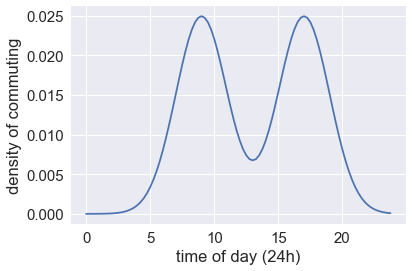

In [191]:
xrange = pd.np.arange(0,24,0.25)
plt.plot(xrange,  mymix(xrange, morning_peak, evening_peak, traffic_std))
plt.xlabel('time of day (24h)')
plt.ylabel('density of commuting')

Well, why not. Let's make bold assumptions about when people like their coffee:

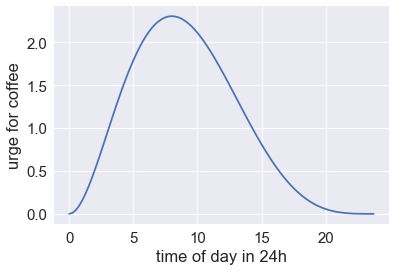

In [192]:
import scipy.stats as ss

coffee_urge = ss.beta.pdf(xrange/24., a=3, b=5)

plt.plot(xrange, coffee_urge)
plt.xlabel('time of day in 24h')
plt.ylabel('urge for coffee')

# we're treating this all haphazardly as quasi-discrete, so we need to normalize
coffee_urge = coffee_urge/sum(coffee_urge)

Great. Let's do an example. Say, the expected number of people with coffee urge at the California Blue Line stop, by 15 minute time interval:

Text(0.5,1,'potential customers per 15 minutes')

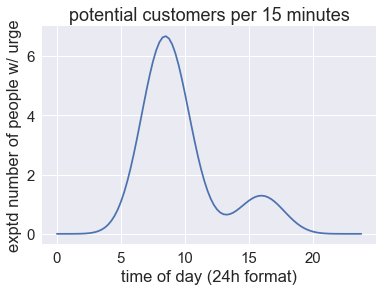

In [193]:
# California travel peak times, as estimated by distance from the loop
cali_morning_peak, cali_evening_peak = station_to_location.loc[
                        station_to_location.stationname=='California/Milwaukee',
                        ['morning_peak','evening_peak']
                        ].values[0]

# for now, let's just use the average weekday ridership (times 2!)
cali_avg_riders = 2*recent_rides_weekday.loc[
                    station_to_location.query('stationname=="California/Milwaukee"').map_id].rides.values[0]

# now we distribute those riders across the day
expected_cali = mymix(xrange, cali_morning_peak, cali_evening_peak, traffic_std)\
                * cali_avg_riders

# find the expected number of people with coffee urge among the riders
plt.plot(xrange, expected_cali * coffee_urge)
plt.xlabel('time of day (24h format)')
plt.ylabel('exptd number of people w/ urge')
plt.title('potential customers per 15 minutes')

That's a bit silly and very rough, but maybe better than nothing.

**TODO**:
1. refactor these rough calculations a bit, clean up
2. calculate plots for all stations, and for all days of the week (instead of for an average day)
3. make maps that shows estimated _coffee customers_, instead of just riders, and for every day of the week
4. for candidate sales locations, plot temporal distributions, so that we can plan when the bike needs to leave the shop

[**go back to the project page**](https://kenben.github.io/ideo_ds/)